In [1]:
import numpy as np
import pandas as pd

from Bio import SeqIO
from Bio.Alphabet import generic_protein
#from sklearn.decomposition import TruncatedSVD
#from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='paper', style='whitegrid', palette='deep', font='serif', font_scale=2, color_codes=True, rc=None)


In [2]:
orf1ab_seqs = list(SeqIO.parse('../../data/coronavirus_orf1ab.fasta','fasta',alphabet=generic_protein))
orf1ab_meta = pd.read_csv("../../data/coronavirus_orf1ab_meta.csv")

In [3]:
d={ 'Accession':[], 'Sequence':[]}
for s in orf1ab_seqs:
    d['Accession'].append(s.name.strip())
    d['Sequence'].append(str(s.seq))

df_seq = pd.DataFrame(d)

df_seq = df_seq.drop_duplicates()

df_seq = df_seq[df_seq.Sequence.apply(lambda s: not s.startswith("L"))].copy()

In [4]:
orf1ab_meta = orf1ab_meta.drop_duplicates()
orf1ab_meta

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date,GenBank_Title
0,YP_009724389,2020-01-13T00:00:00Z,Severe acute respiratory syndrome-related coro...,7096,China,Homo sapiens,NaN,2019-12,orf1ab polyprotein [Severe acute respiratory s...
1,YP_009555238,2019-02-21T00:00:00Z,Betacoronavirus 1,7095,USA,NaN,NaN,NaN,Orf1ab [Human coronavirus OC43]
2,YP_002308478,2018-08-24T00:00:00Z,Bulbul coronavirus HKU11,6264,Hong Kong,Pycnonotus jocosus,NaN,2007-01,orf1ab polyprotein [Bulbul coronavirus HKU11-934]
3,YP_009513008,2018-08-24T00:00:00Z,Hedgehog coronavirus 1,7150,Germany,Erinaceus europaeus,feces,2012,orf1ab [Betacoronavirus Erinaceus/VMC/DEU/2012]
4,YP_009513020,2018-08-24T00:00:00Z,Coronavirus HKU15,6267,China: Hong Kong,Sus scrofa,NaN,2010,replicase polyprotein [Porcine coronavirus HKU15]
...,...,...,...,...,...,...,...,...,...
2711,QIU78777,2020-04-06T00:00:00Z,Severe acute respiratory syndrome-related coro...,7096,Spain,Homo sapiens,NaN,2020-03-10,ORF1ab polyprotein [Severe acute respiratory s...
2712,QIU78717,2020-04-06T00:00:00Z,Severe acute respiratory syndrome-related coro...,7096,Spain,Homo sapiens,NaN,2020-03-10,ORF1ab polyprotein [Severe acute respiratory s...
2713,QIU78705,2020-04-06T00:00:00Z,Severe acute respiratory syndrome-related coro...,7096,Spain,Homo sapiens,NaN,2020-03-09,ORF1ab polyprotein [Severe acute respiratory s...
2714,QIU78741,2020-04-06T00:00:00Z,Severe acute respiratory syndrome-related coro...,7096,Spain,Homo sapiens,NaN,2020-03-10,ORF1ab polyprotein [Severe acute respiratory s...


In [5]:
df = df_seq.merge(orf1ab_meta, on='Accession', how='left')

### new columns
df['Protein'] = df.GenBank_Title.apply(lambda s: s.split("[")[0].strip())
df[df.Protein == 'orf1ab polyprotein, partial']

df['Country'] = df.Geo_Location.apply(lambda s: s.split(':')[0] if isinstance(s, str) else s )

df['Host_agg'] = df.Host.apply(lambda s: s.split(" ")[0] if isinstance(s, str) else s )
df['is_sc2'] = df.GenBank_Title.apply(lambda s: "coronavirus 2" in s)


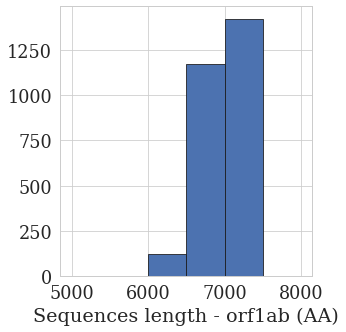

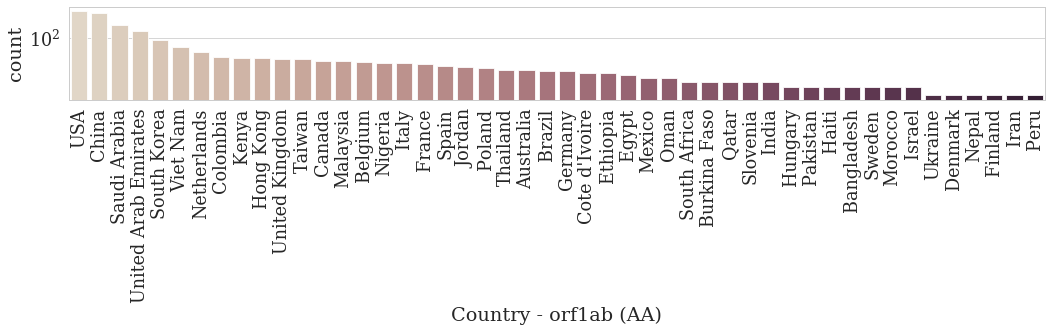

<Figure size 432x288 with 0 Axes>

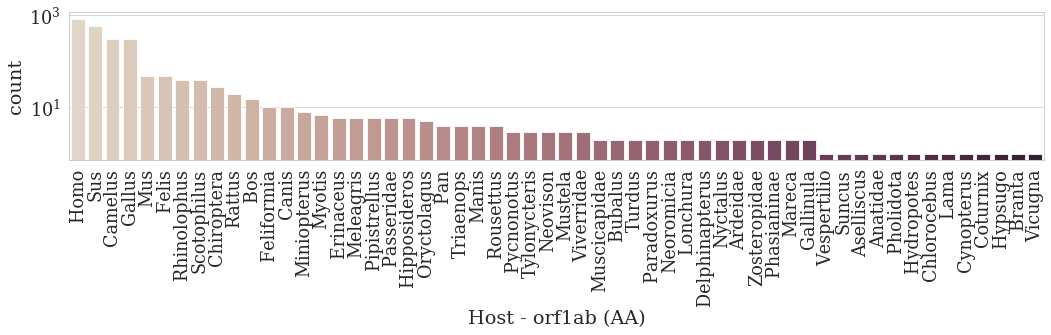

In [6]:
fig, ax = plt.subplots(1, figsize=(5,5))
g1 = df.Length.hist(ax = ax, edgecolor="k", bins=np.arange(5000,8001, 500))
g1.set_xlabel('Sequences length - orf1ab (AA)')
plt.tight_layout()
plt.savefig("plots/EDA/orf1ab_lengths_beta_proteins.pdf")
#plt.savefig("lengths.png", dpi=600)

## I'll group countries ignoring second-level data.
## Losing some information to provide better visualization

##by country
fig, ax = plt.subplots(1, figsize=(15,5))
chart = sns.countplot(x="Country", palette="ch:.25", data=df, ax=ax,
                     order = df['Country'].value_counts().index);
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_xlabel('Country - orf1ab (AA)')
chart.set_yscale("log")

plt.tight_layout()
plt.savefig("plots/EDA/orf1ab_countries_beta_proteins.pdf")
plt.show()


#########
plt.clf()

##by host
fig, ax = plt.subplots(1, figsize=(15,5))
chart = sns.countplot(x="Host_agg", palette="ch:.25", data=df, ax=ax,
                     order = df['Host_agg'].value_counts().index);
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_xlabel('Host - orf1ab (AA)')
chart.set_yscale("log")

plt.tight_layout()
plt.savefig("plots/EDA/orf1ab_host_beta_proteins.pdf")
plt.show()

In [7]:
proteins = df.Sequence.copy()

kmer_len = 3

#let's keep the original indexing to allow lookups from the starting data
corpus = []
ordered_indexes = [] #probably overkill, but let's avoid forgetting the indexes to retrieve metadata

for i, seq in proteins.iteritems():
    ordered_indexes.append(i)
    corpus.append([seq[j:j+kmer_len] for j in np.arange(0, len(seq)-kmer_len)])
    
#All that is required is that the input yields one sentence (list of utf8 words) after another.

In [8]:
from gensim.models import Word2Vec

size= 1000
tot_epochs= 100

#PCA
n_components= 10

#tSNE
perplexity=500
n_iter = 1000

In [9]:
#model = Word2Vec(sentences=corpus, min_count=1, size=size, iter=tot_epochs)
#model = Word2Vec.load(f"models/k_3_size_{size}_iter_{tot_epochs}.model")
model = Word2Vec.load(f"../../../embeddings/word2vec_kmers3_size1000_epochs100.model")

In [10]:
#get embedded vectors for other usages
vecs=[]
geo_labels = []
date_labels = []
host_labels = []
host_agg_labels = []
gen_bank_labels = []
gen_bank_labels_2 = []
sc2_labels = []
species_labels = []
accession_labels = []

for i, sentence in zip(ordered_indexes, corpus):

    vecs.append(np.mean([model.wv[word] for word in sentence], axis=0))
    
    geo_labels.append(df.iloc[i]['Country'])
    date_labels.append(df.iloc[i]['Release_Date'])
    host_labels.append(df.iloc[i]['Host'])
    host_agg_labels.append(df.iloc[i]['Host_agg'])
    gen_bank_labels.append(df.iloc[i]['GenBank_Title'])
    gen_bank_labels_2.append(df.iloc[i]['GenBank_Title'].split("[")[1].split("]")[0])
    sc2_labels.append(df.iloc[i]['is_sc2'])
    species_labels.append(df.iloc[i]['Species'])
    accession_labels.append(df.iloc[i]['Accession'])

# Visualization
## summarize sentences (genomes) by making word means (or sum, whatever, their length is pretty much the same) and tSNE the results

#### make it as colors/labels are interchangeable

In [11]:
## PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(vecs)
X_scaled = scaler.transform(vecs)
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X_scaled)

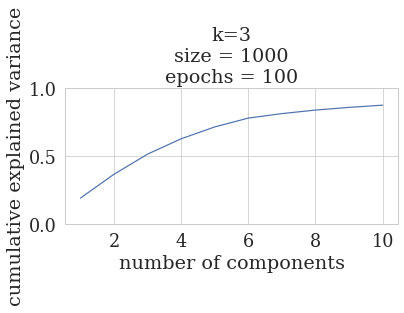

In [12]:
plt.plot(np.arange(1, n_components +1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.ylim([0,1])

plt.title("k=3\nsize = {}\nepochs = {}".format(size, tot_epochs))
plt.tight_layout()
plt.savefig(f"plots/k_{kmer_len}_PCA_cumsum_best_model.pdf")
plt.savefig(f"plots/k_{kmer_len}_PCA_cumsum_best_model.png", dpi = 600)

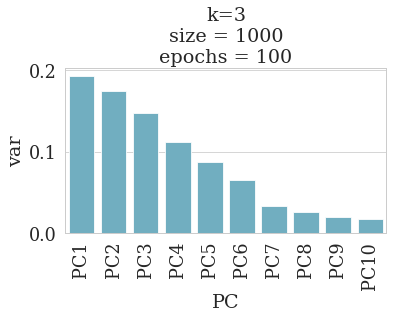

In [13]:
df_pca = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC'+str(i) for i in np.arange(1,n_components+1)]})
g= sns.barplot(x='PC',y="var", 
           data=df_pca, color="c");
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.tight_layout()
plt.title("k=3\nsize = {}\nepochs = {}".format(size, tot_epochs))
plt.savefig(f"plots/k_{kmer_len}_PCA_single_best_model.pdf")
plt.savefig(f"plots/k_{kmer_len}_PCA_single_best_model.png", dpi = 600)

In [14]:
## tSNE

from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model, ordered_indexes, corpus, df=df, label="Species",
                     perplexity=30, n_iter = 500):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)
    
    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later

    for i, sentence in zip(ordered_indexes, corpus):

        vectors.append(np.mean([model.wv[word] for word in sentence], axis=0))
        labels.append(df.iloc[i][label])
        
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=perplexity, n_iter=n_iter)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [15]:
x_vals, y_vals, labels = reduce_dimensions(model, ordered_indexes, corpus, 
                                                         label="Protein",
                                           perplexity =perplexity, n_iter=n_iter)

In [16]:
from sklearn import preprocessing

def plot_with_matplotlib(x_vals, y_vals, labels, color_labels, figsize = (30,30)):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    le = preprocessing.LabelEncoder()
    le.fit(color_labels)
    cmappable_labels = le.transform(color_labels)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    unique = np.unique(color_labels)
    colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
    for i, u in enumerate(unique):
        xi = [x_vals[j] for j  in range(len(x_vals)) if color_labels[j] == u]
        yi = [y_vals[j] for j  in range(len(x_vals)) if color_labels[j] == u]
        
        edgecolor =None
        if u == "Homo":
            edgecolor ='k'
        elif u == "Felis":
            edgecolor ='r'
        elif u == "nan":
            colors[i] = 'w'
        plt.scatter(xi, yi, c=(colors[i],), label=str(u), edgecolor=edgecolor)
        
    plt.legend(bbox_to_anchor=(1.0, 0.5, 0.5, 0.2), loc='upper left')
    
    selected_indices = [i for i,s in enumerate(labels) if s]
    for i in selected_indices:
        plt.annotate('x', (x_vals[i], y_vals[i]))
    
    return fig,ax

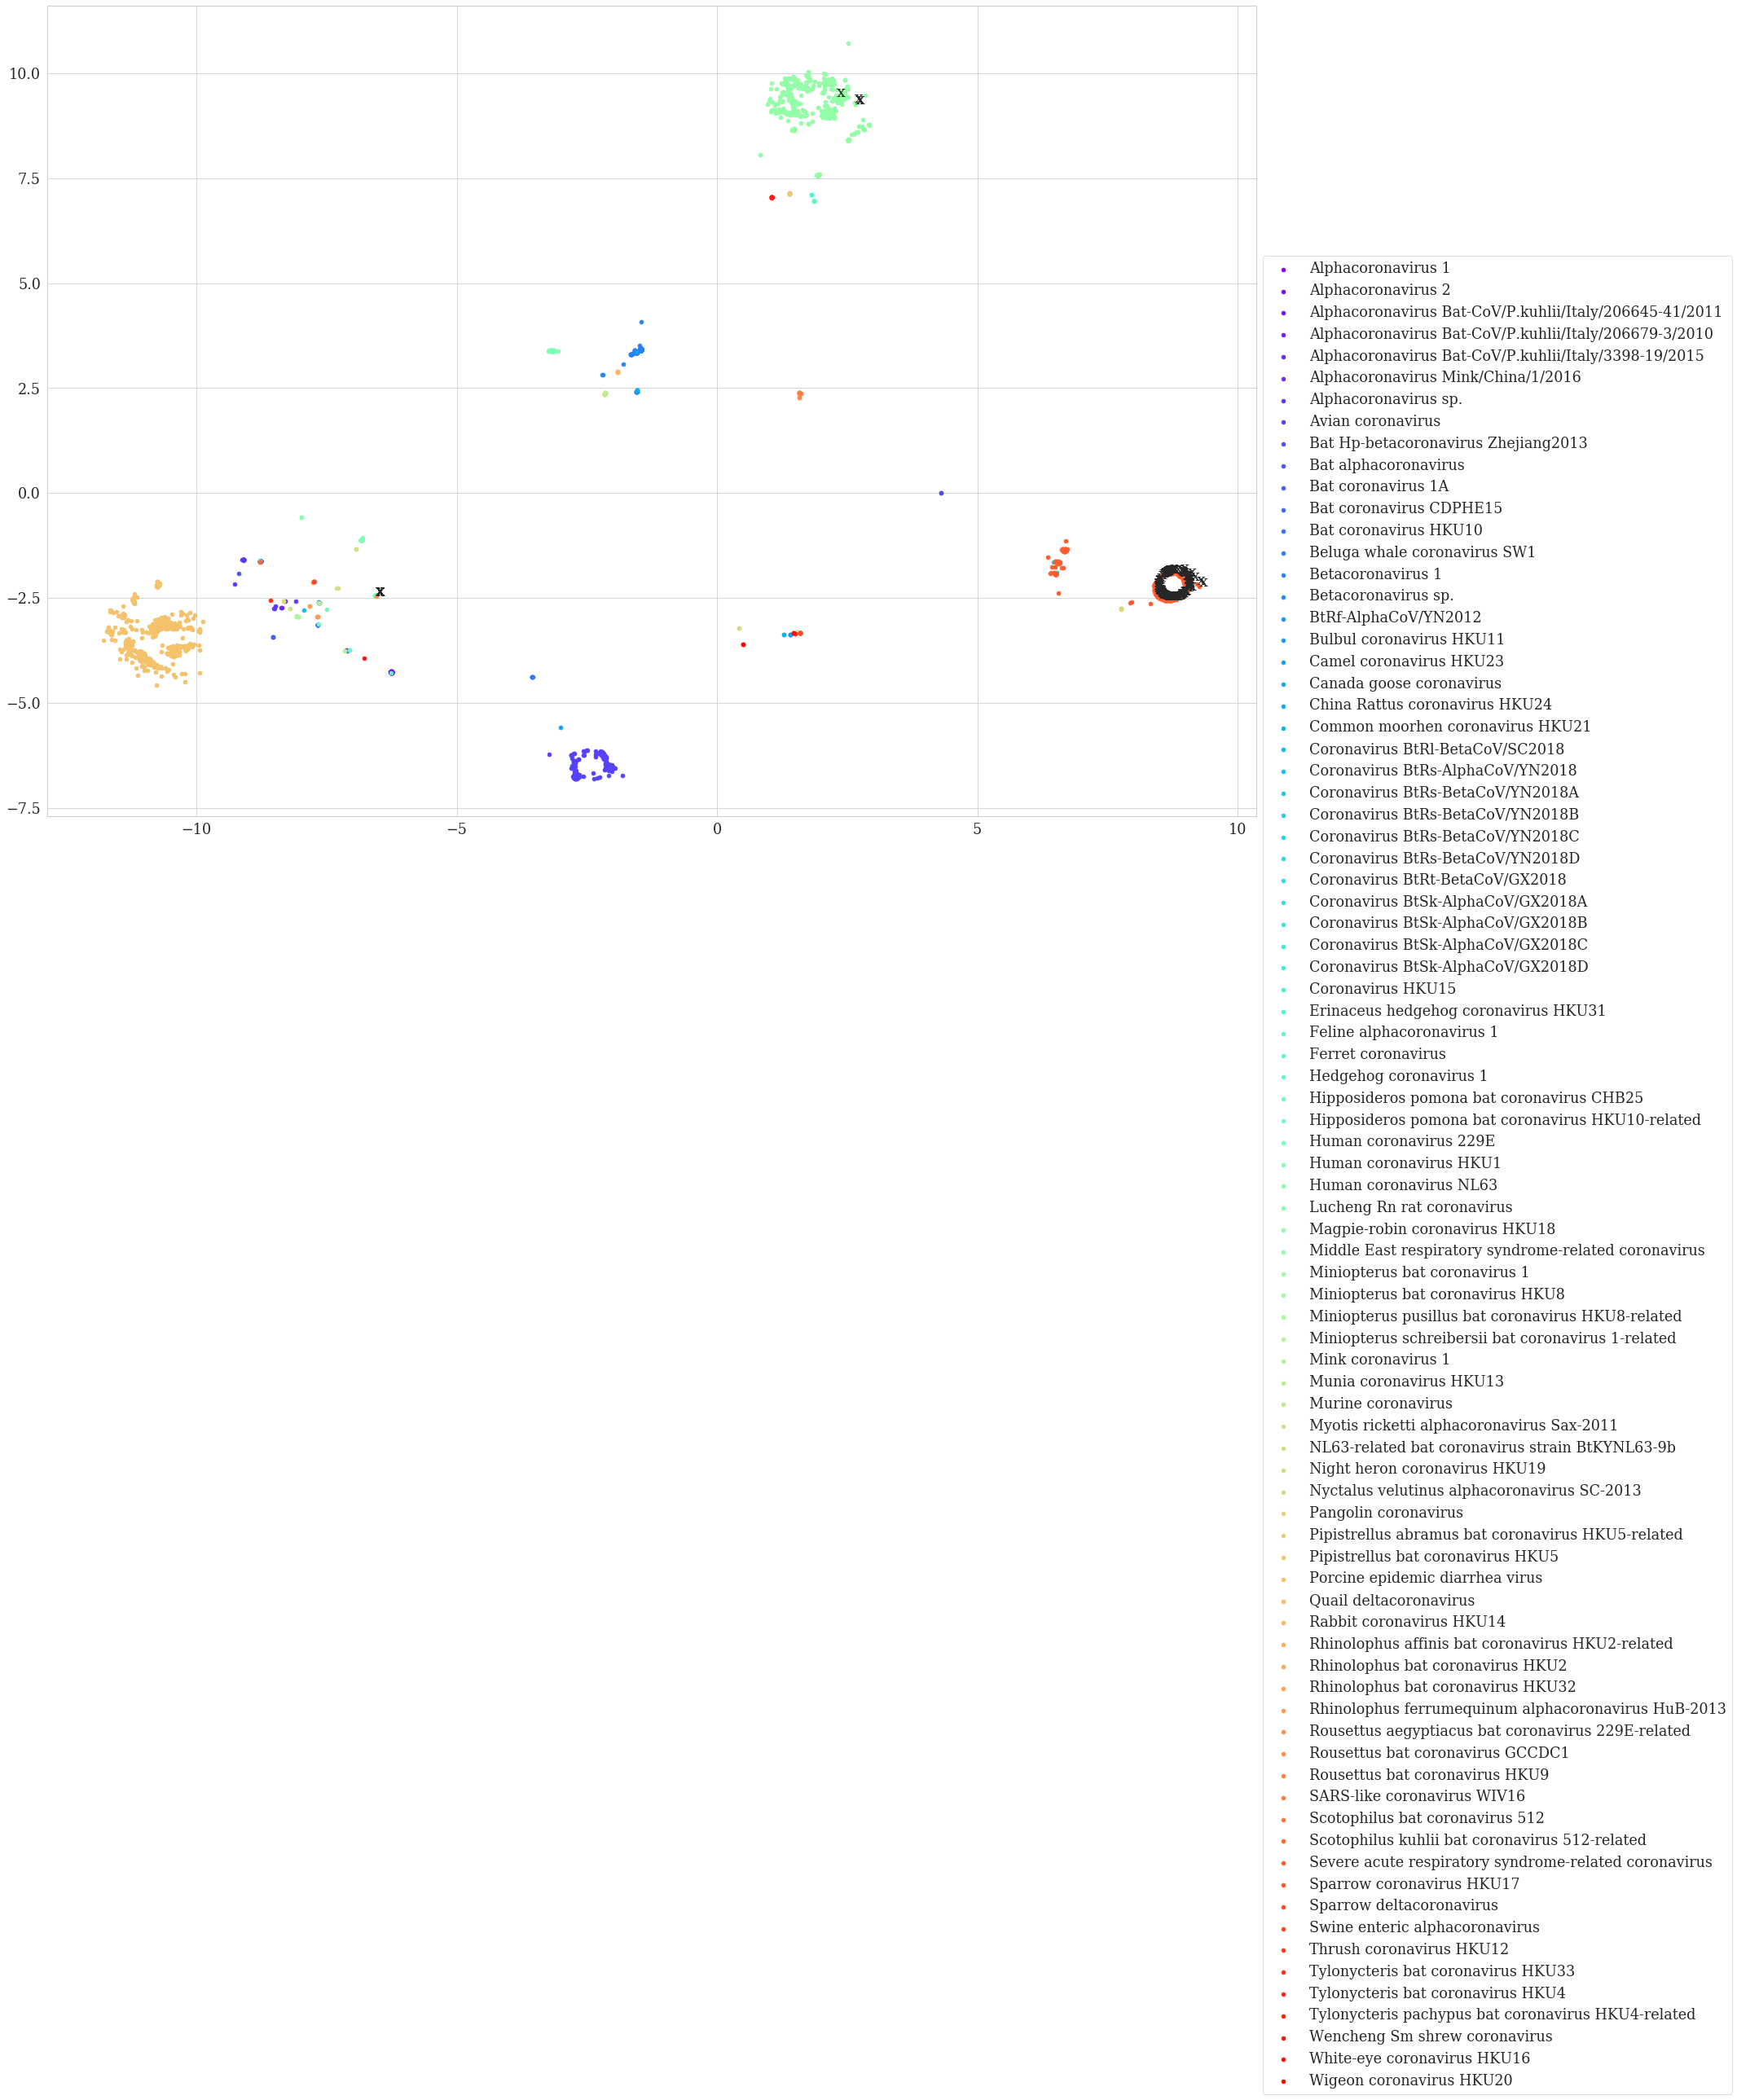

In [17]:
##color_labels
_,_= plot_with_matplotlib(x_vals, y_vals, sc2_labels, species_labels)
plt.tight_layout()
plt.savefig(f"plots/byspecies_tsne_orf1ab_w2vsize_{size}_epochs_{tot_epochs}_perpl_{perplexity}_k_{kmer_len}.pdf")

##TODO remove nan, plot with different labels -- remove low count species

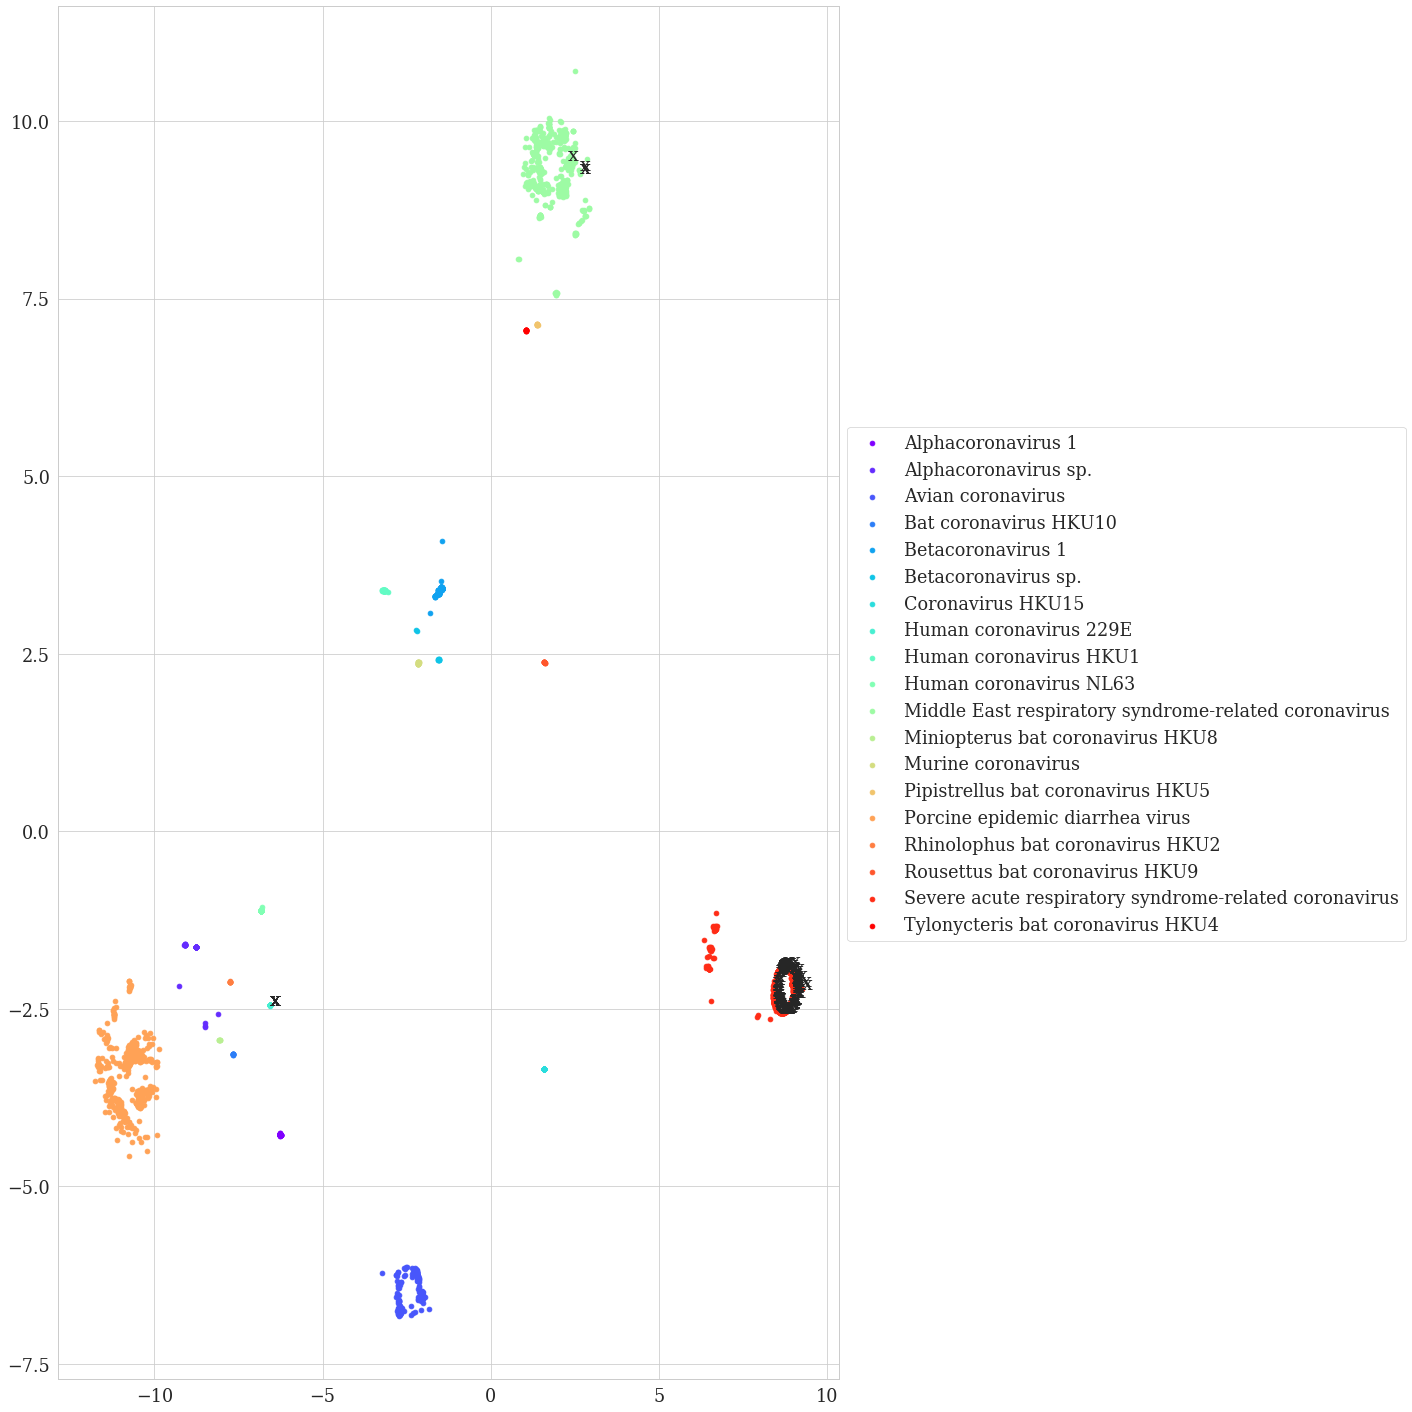

In [18]:
#same plot above, but with less represented species removed
thr = 5

c = np.unique(species_labels, return_counts = True)
d = {k:v for k,v in zip(c[0],c[1])}

x_vals_thr = [x_vals[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
y_vals_thr = [y_vals[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
sc2_labels_thr = [sc2_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
species_labels_thr = [species_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
gen_bank_labels_thr = [gen_bank_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]

_,_= plot_with_matplotlib(x_vals_thr, y_vals_thr, sc2_labels_thr, species_labels_thr, figsize=(20,20))
plt.tight_layout()
plt.savefig(f"plots/byspecies_gt_{thr}_tsne_orf1ab_w2vsize_{size}_epochs_{tot_epochs}_perpl_{perplexity}_k_{kmer_len}.pdf")


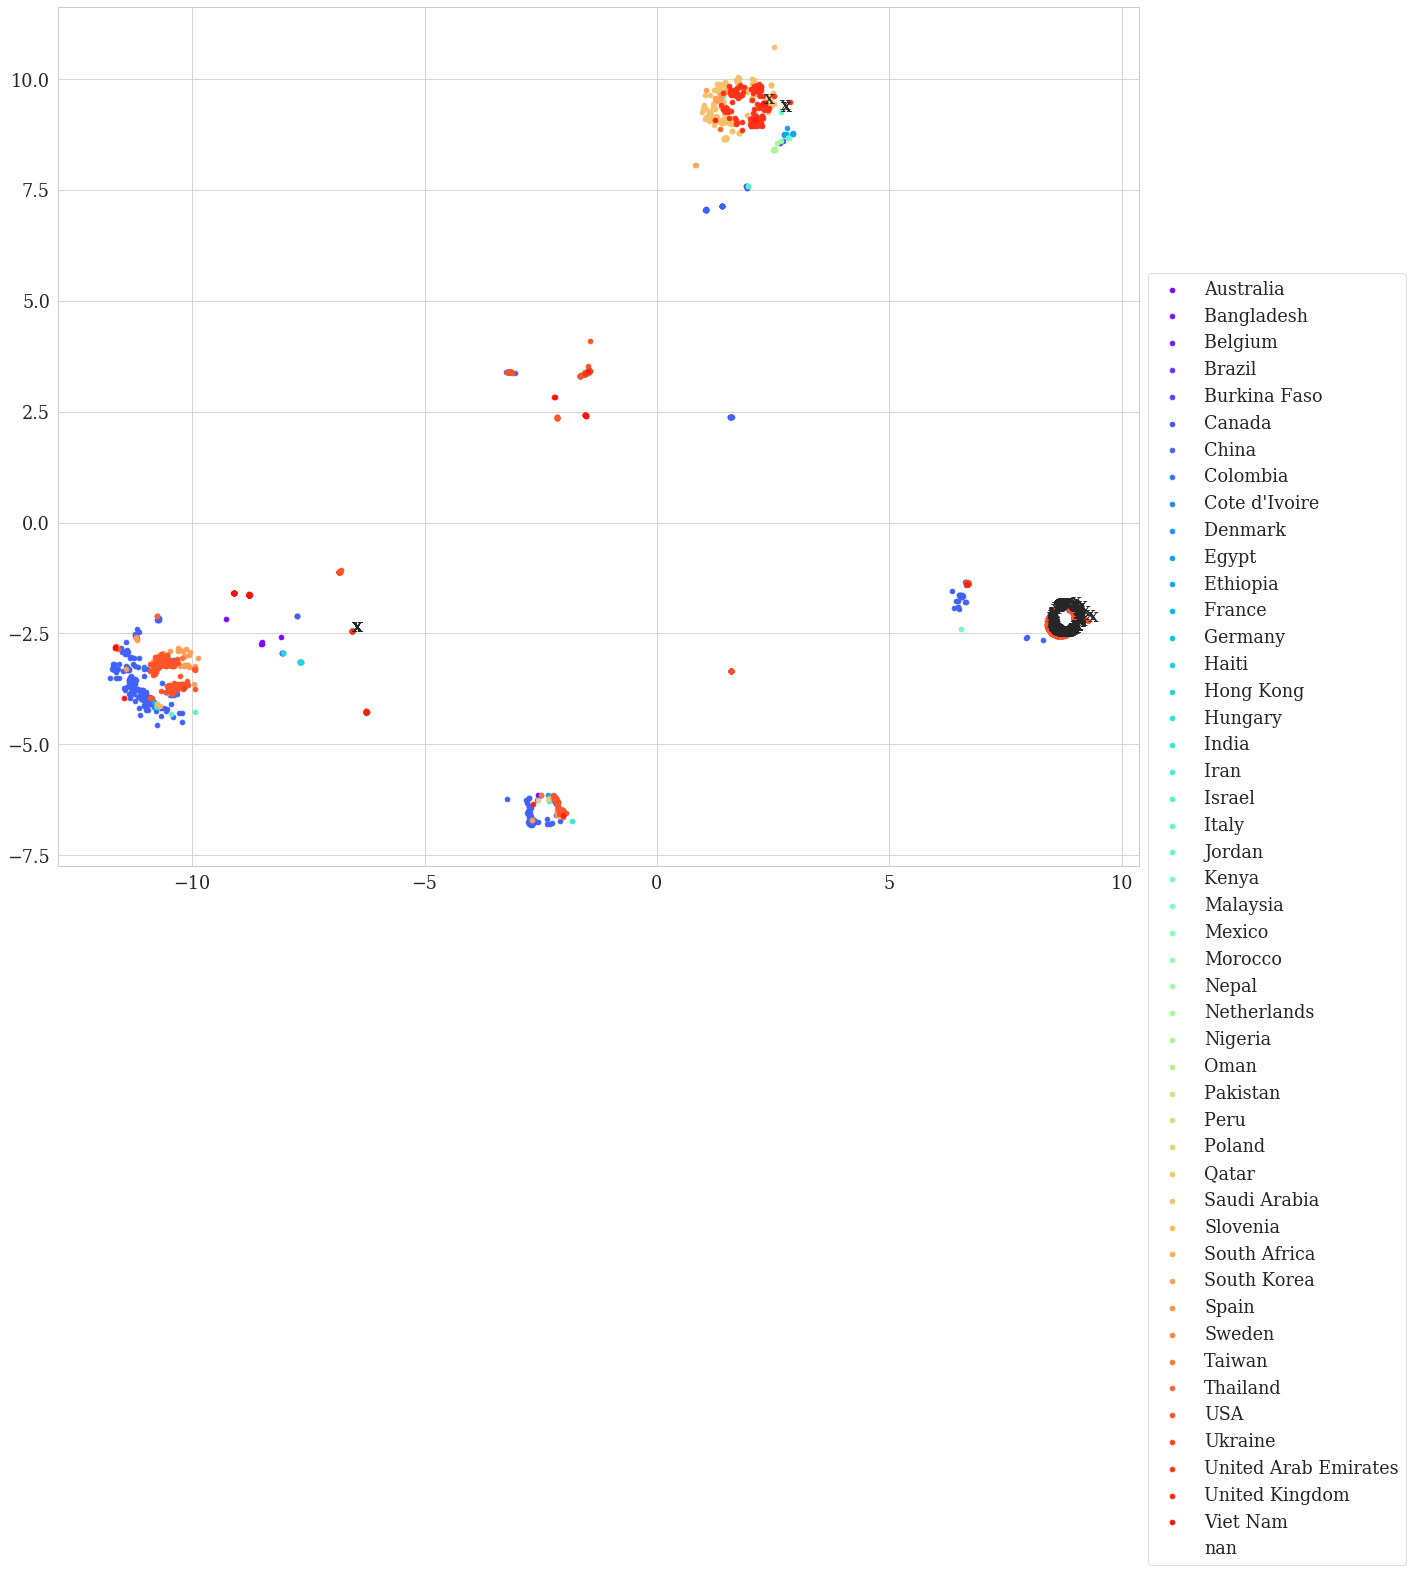

In [19]:
#same plot above, with geo
thr = 5

c = np.unique(species_labels, return_counts = True)
d = {k:v for k,v in zip(c[0],c[1])}

x_vals_thr = [x_vals[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
y_vals_thr = [y_vals[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
sc2_labels_thr = [sc2_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
species_labels_thr = [species_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
gen_bank_labels_thr = [gen_bank_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]
geo_labels_thr = [geo_labels[i] for i, spec in enumerate(species_labels) if d[spec] > thr]

_,_= plot_with_matplotlib(x_vals_thr, y_vals_thr, sc2_labels_thr, geo_labels_thr, figsize=(20,20))
plt.tight_layout()
plt.savefig(f"plots/bygeo_gt_{thr}_tsne_orf1ab_w2vsize_{size}_epochs_{tot_epochs}_perpl_{perplexity}_k_{kmer_len}.pdf")


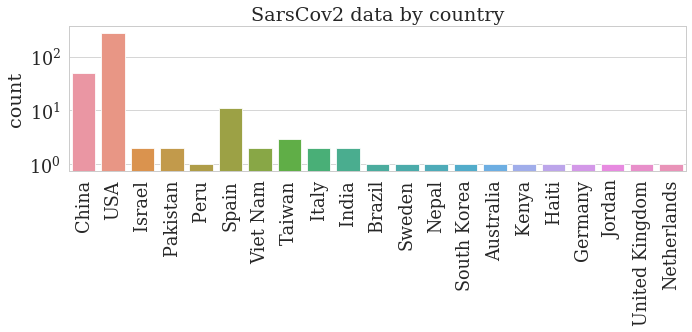

In [20]:
fig = plt.figure(figsize = (10,5))
g= sns.countplot(x=[geo_labels[i] for i,s in enumerate(gen_bank_labels) if "coronavirus 2" in s])
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("SarsCov2 data by country")
plt.tight_layout()
plt.savefig("plots/EDA/orf1ab_sc2_bycountry_prot.pdf")

## Trees

In [21]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
dm = pdist(vecs, 'cosine') # X è il vettore dei vettori di embedding
method = 'ward'
Z = linkage(dm, method=method, metric='cosine', optimal_ordering=False)

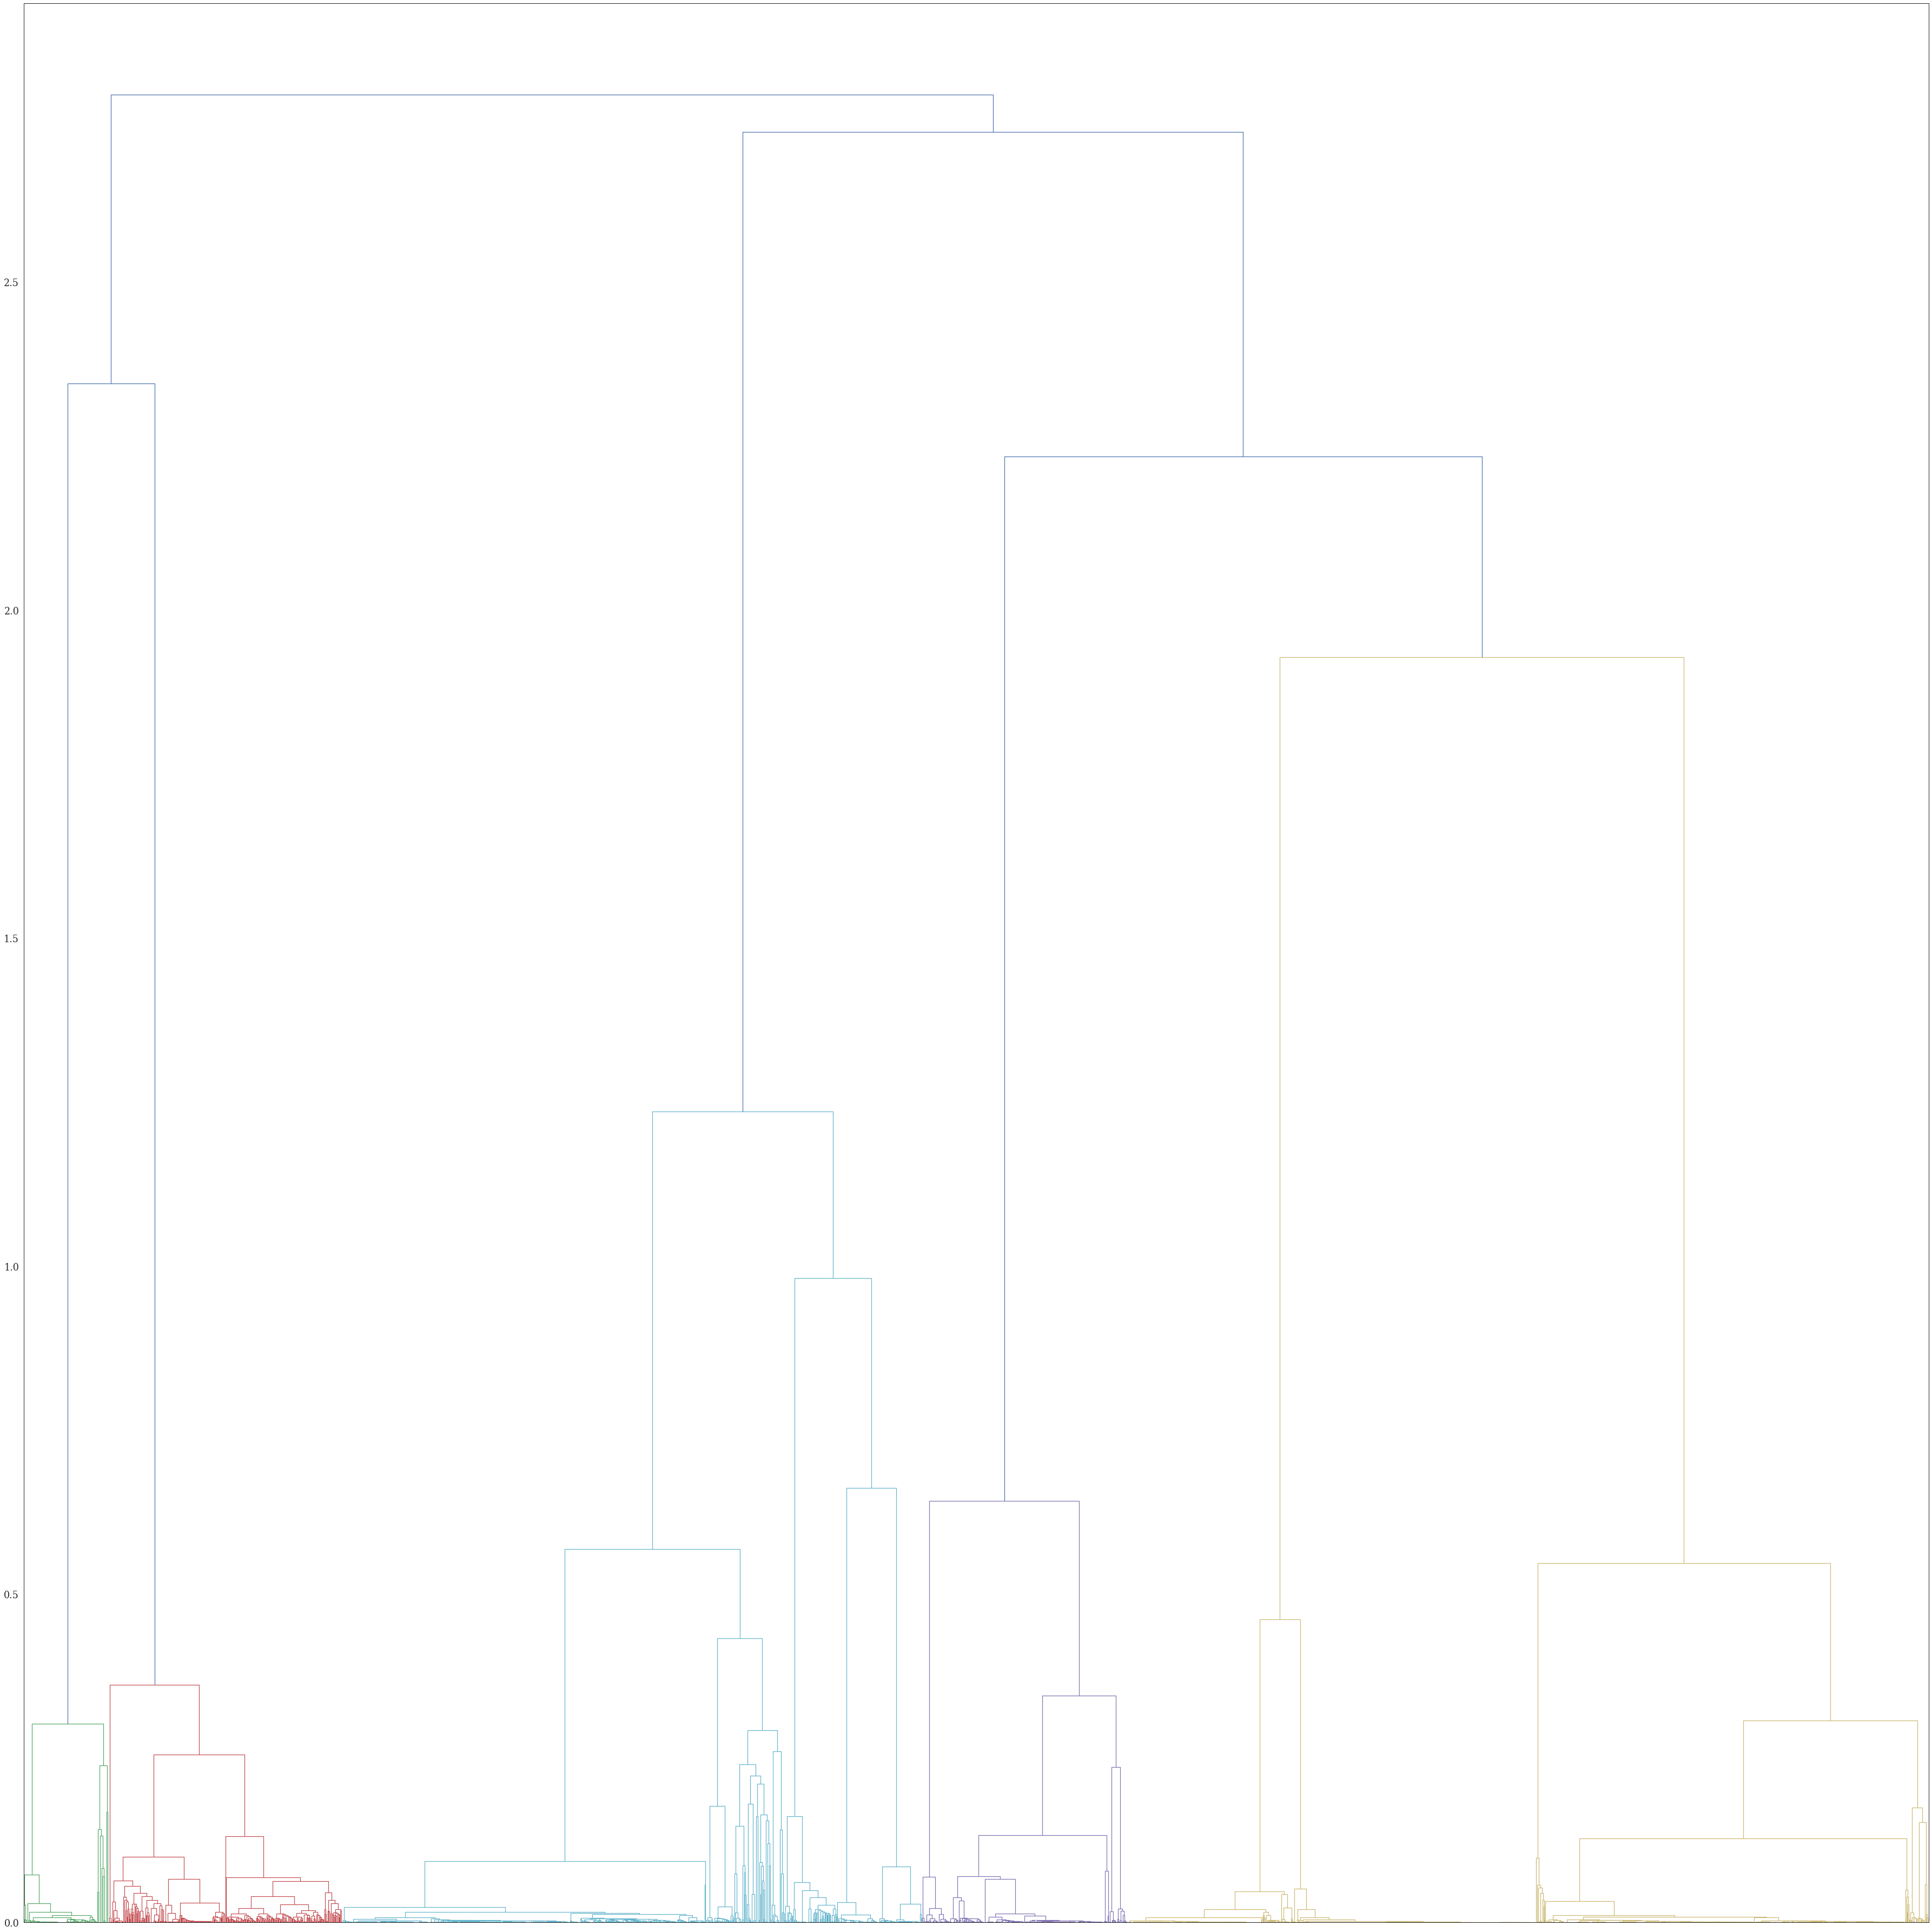

In [22]:
sns.set(context='paper', style='white', palette='deep', font='serif', font_scale=2, color_codes=True, rc=None)

fig, ax = plt.subplots(1, figsize=(50,50))
dendrogram(Z,
            orientation='top',
            no_labels= True,
            distance_sort='descending',
              ax = ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig(f"plots/tree_k_{kmer_len}_best.final.pdf")


In [23]:
def get_clusters(linkage, numclust, labels, norm=True, thr=5):
    """extracts numclust clusters from the linkage matrix
    if norm: True returns the fraction with respect to the total number of points with the same label"""
    d = {}
    totals = {}
    fl = fcluster(linkage,numclust,criterion='maxclust')
    labs = np.array(labels)
    
    unique_elements, counts_elements = np.unique(labs, return_counts=True)
    for host, counts in zip(unique_elements, counts_elements):
        totals[host] = counts
    
    for i in np.arange(1, numclust+1):
        d[i] = {}
        uniq, cnt = np.unique(labs[fl == i], return_counts=True)
        for host, counts in zip(uniq, cnt):
            if totals[host] > thr:
                d[i][host] = counts/totals[host]
    return d

numclust = 7    
get_clusters(Z, numclust, gen_bank_labels_2, thr=2)

#nearest neighbours are BAT,SarsCov,pangolin and porcine+sparrow deltacoronavirus(or HKU15 for pigs)

{1: {'Porcine coronavirus HKU15': 1.0,
  'Porcine deltacoronavirus': 1.0,
  'Sparrow deltacoronavirus': 1.0},
 2: {'Avian coronavirus': 1.0,
  'Bottlenose dolphin coronavirus HKU22': 1.0,
  'Infectious bronchitis virus': 1.0,
  'Turkey coronavirus': 1.0},
 3: {'Alphacoronavirus sp.': 1.0,
  'Hipposideros bat coronavirus HKU10': 1.0,
  'NL63-related bat coronavirus': 1.0,
  'Porcine epidemic diarrhea virus': 1.0,
  'Rhinolophus bat coronavirus HKU2': 1.0,
  'Rousettus bat coronavirus HKU10': 1.0},
 4: {'Camel alphacoronavirus': 1.0,
  'Camel alphacoronavirus Camel229E': 1.0,
  'Canine coronavirus': 1.0,
  'Feline coronavirus': 1.0,
  'Feline infectious peritonitis virus': 1.0,
  'Human coronavirus 229E': 1.0,
  'Human coronavirus NL63': 1.0},
 5: {'Betacoronavirus HKU24': 1.0,
  'Betacoronavirus sp.': 1.0,
  'Bovine coronavirus': 1.0,
  'Dromedary camel coronavirus HKU23': 1.0,
  'Human coronavirus HKU1': 1.0,
  'Human coronavirus OC43': 1.0,
  'Murine coronavirus': 1.0,
  'Murine hepat

In [24]:
numclust = 7
get_clusters(Z, numclust, gen_bank_labels_2, thr=2)

#relaxing the threshold, Pangolin comes in (other known neighbours)
#and Sparrow deltacoronavirus (unknown?)

##recombination similarity? where are pangolin/porcine and sparrow?

{1: {'Porcine coronavirus HKU15': 1.0,
  'Porcine deltacoronavirus': 1.0,
  'Sparrow deltacoronavirus': 1.0},
 2: {'Avian coronavirus': 1.0,
  'Bottlenose dolphin coronavirus HKU22': 1.0,
  'Infectious bronchitis virus': 1.0,
  'Turkey coronavirus': 1.0},
 3: {'Alphacoronavirus sp.': 1.0,
  'Hipposideros bat coronavirus HKU10': 1.0,
  'NL63-related bat coronavirus': 1.0,
  'Porcine epidemic diarrhea virus': 1.0,
  'Rhinolophus bat coronavirus HKU2': 1.0,
  'Rousettus bat coronavirus HKU10': 1.0},
 4: {'Camel alphacoronavirus': 1.0,
  'Camel alphacoronavirus Camel229E': 1.0,
  'Canine coronavirus': 1.0,
  'Feline coronavirus': 1.0,
  'Feline infectious peritonitis virus': 1.0,
  'Human coronavirus 229E': 1.0,
  'Human coronavirus NL63': 1.0},
 5: {'Betacoronavirus HKU24': 1.0,
  'Betacoronavirus sp.': 1.0,
  'Bovine coronavirus': 1.0,
  'Dromedary camel coronavirus HKU23': 1.0,
  'Human coronavirus HKU1': 1.0,
  'Human coronavirus OC43': 1.0,
  'Murine coronavirus': 1.0,
  'Murine hepat

In [25]:
numclust = 17
get_clusters(Z, numclust, gen_bank_labels_2, thr=2)

{1: {'Porcine coronavirus HKU15': 1.0,
  'Porcine deltacoronavirus': 1.0,
  'Sparrow deltacoronavirus': 1.0},
 2: {'Bottlenose dolphin coronavirus HKU22': 1.0},
 3: {'Avian coronavirus': 1.0,
  'Infectious bronchitis virus': 1.0,
  'Turkey coronavirus': 1.0},
 4: {'Alphacoronavirus sp.': 0.02564102564102564,
  'Porcine epidemic diarrhea virus': 1.0},
 5: {'Alphacoronavirus sp.': 0.8717948717948718},
 6: {'Alphacoronavirus sp.': 0.10256410256410256,
  'Hipposideros bat coronavirus HKU10': 1.0,
  'NL63-related bat coronavirus': 1.0,
  'Rhinolophus bat coronavirus HKU2': 1.0,
  'Rousettus bat coronavirus HKU10': 1.0},
 7: {'Canine coronavirus': 1.0,
  'Feline coronavirus': 1.0,
  'Feline infectious peritonitis virus': 1.0},
 8: {'Human coronavirus NL63': 1.0},
 9: {'Camel alphacoronavirus': 1.0,
  'Camel alphacoronavirus Camel229E': 1.0,
  'Human coronavirus 229E': 1.0},
 10: {'Human coronavirus HKU1': 1.0},
 11: {'Betacoronavirus sp.': 0.2,
  'Bovine coronavirus': 1.0,
  'Dromedary camel

In [26]:
import ete3
from scipy.cluster.hierarchy import fcluster, to_tree
from covid_lib import *
# remove special characters that could break the tree (i.e.: ":;,()")
leaf_names=[s.replace(":","").replace(";","").replace(",","").replace("(","").replace(")","") for s in gen_bank_labels_2]

tree = to_tree(Z,False)
t1 = ete3.Tree(getNewick(tree, "", tree.dist, leaf_names))
t1.write(format=1, outfile=f"new_tree_w2vsize_{size}_epochs_{tot_epochs}_genbank.nw",)

In [81]:
Z

array([[0.00000000e+00, 2.19000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 2.65700000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 2.57700000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [5.41200000e+03, 5.41800000e+03, 1.54314389e+01, 6.10000000e+02],
       [5.42100000e+03, 5.42400000e+03, 1.67132617e+01, 1.43500000e+03],
       [5.42300000e+03, 5.42500000e+03, 2.25779751e+01, 2.71400000e+03]])